In [ ]:
import torch
import torchvision
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from mtcnn import MTCNN
from keras_facenet import FaceNet
from scipy.spatial.distance import cosine

In [17]:

def get_face(img, res):
    x1, y1, width, height = map(int, map(abs, res))
    x2, y2 = x1 + width, y1 + height
    return img[y1:y2, x1:x2], (x1, y1), (x2, y2)

def get_encode(face_encoder, face, size=(160, 160)):
    face_resized = cv2.resize(face, size).astype('float32')
    return face_encoder.embeddings(np.expand_dims(face_resized, axis=0))[0]

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def decode(label):
    return {1: "People", 2: "Dog"}.get(label, "Unknown")

def mtcnn_facenet(face_detector, face_encoder, img_cropped, encoding_dict, recognition_t=0.5):
    img_rgb = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB)
    results = face_detector.detect_faces(img_rgb)
    
    for res in results:
        face_cropped, pt_1, pt_2 = get_face(img_rgb, res['box'])
        encode = get_encode(face_encoder, face_cropped)
        name, min_distance = 'Unknown', float("inf")
        
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < min_distance:
                name, min_distance = db_name, dist
        
        return pt_1, pt_2, name, min_distance
    
    return None, None, "Unknown", float("inf")
    

In [ ]:

# Initialize Face Detection and Recognition Models
face_detector = MTCNN()
face_encoder = FaceNet()

# Load Pre-trained Encoding Dictionary
encoding_dict = load_pickle('../models/facenet_encodings.pkl')

# Check CUDA Availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Load Faster R-CNN Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 3)
model.load_state_dict(torch.load('../models/detection_model.pth', map_location=device))
model.to(device)
model.eval()
    

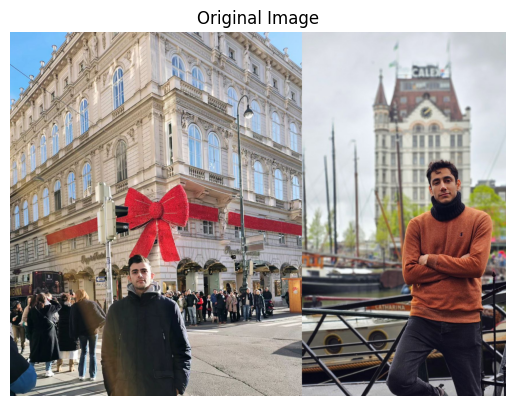

In [4]:

# Load Image
img_path = "../data/test.jpg"
img_pil = Image.open(img_path).convert('RGB')
img_cv = cv2.imread(img_path)
tensor = torchvision.transforms.functional.to_tensor(img_pil).to(device)

# Display Original Image
plt.imshow(img_pil)
plt.title("Original Image")
plt.axis("off")
plt.show()
    

In [ ]:

# Run Object Detection
with torch.no_grad():
    predictions = model([tensor])

# Extract Predictions
boxes, labels, scores = predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']

# Display Image with Bounding Boxes
plt.imshow(tensor.permute(1, 2, 0).cpu().numpy())
ax = plt.gca()

for box, label, score in zip(boxes, labels, scores):
    if score > 0.6:
        box_np = box.cpu().numpy()
        rect = Rectangle((box_np[0], box_np[1]), box_np[2] - box_np[0], box_np[3] - box_np[1],
                         fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(box_np[0], box_np[1], decode(int(label.cpu().numpy())), fontsize=9, color='red')

plt.title("Faster R-CNN Object Detection")
plt.show()
    

1/1 [==============================] - 0s 36ms/step


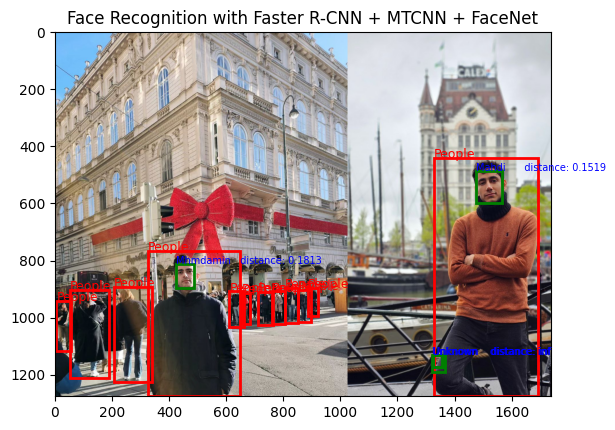

In [18]:

plt.imshow(tensor.permute(1, 2, 0).cpu().numpy())
ax = plt.gca()

for box, label, score in zip(boxes, labels, scores):
    if score > 0.6:
        box_np = box.cpu().numpy()
        rect = Rectangle((box_np[0], box_np[1]), box_np[2] - box_np[0], box_np[3] - box_np[1],
                         fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(box_np[0], box_np[1], decode(int(label.cpu().numpy())), fontsize=9, color='red')

        if decode(int(label.cpu().numpy())) == "People":
            people_cropped, t1, t2 = get_face(img_cv, box_np)
            pt_1, pt_2, name, dist = mtcnn_facenet(face_detector, face_encoder, people_cropped, encoding_dict)

            if pt_1 and pt_2:
                rect2 = Rectangle((box_np[0] + pt_1[0], box_np[1] + pt_1[1]), pt_2[0] - pt_1[0], pt_2[1] - pt_1[1],
                                  fill=False, edgecolor='green', linewidth=2)
                ax.add_patch(rect2)
                ax.text(box_np[0] + pt_1[0], box_np[1] + pt_1[1], f"{name:10} distance: {dist:.4f}", fontsize=7, color='blue')

plt.title("Face Recognition with Faster R-CNN + MTCNN + FaceNet")
plt.show()
    